In [1]:
!pip install imutils


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3 
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout

from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

print("yay")

yay


In [2]:
!mkdir E:\inc_new\tmp\prepared_data\

!mkdir E:\inc_new\tmp\prepared_data\benign
!mkdir E:\inc_new\tmp\prepared_data\PreB
!mkdir E:\inc_new\tmp\prepared_data\ProB
!mkdir E:\inc_new\tmp\prepared_data\EarlyPreB

!mkdir E:\inc_new\tmp\prepared_test\

!mkdir E:\inc_new\tmp\prepared_test\benign
!mkdir E:\inc_new\tmp\prepared_test\PreB
!mkdir E:\inc_new\tmp\prepared_test\ProB
!mkdir E:\inc_new\tmp\prepared_test\EarlyPreB


A subdirectory or file E:\inc_new\tmp\prepared_data already exists.
A subdirectory or file E:\inc_new\tmp\prepared_data\benign already exists.
A subdirectory or file E:\inc_new\tmp\prepared_data\PreB already exists.
A subdirectory or file E:\inc_new\tmp\prepared_data\ProB already exists.
A subdirectory or file E:\inc_new\tmp\prepared_data\EarlyPreB already exists.
A subdirectory or file E:\inc_new\tmp\prepared_test already exists.
A subdirectory or file E:\inc_new\tmp\prepared_test\benign already exists.
A subdirectory or file E:\inc_new\tmp\prepared_test\PreB already exists.
A subdirectory or file E:\inc_new\tmp\prepared_test\ProB already exists.
A subdirectory or file E:\inc_new\tmp\prepared_test\EarlyPreB already exists.


In [3]:
import random
from imutils import paths
from sklearn.model_selection import train_test_split

data_dir = r'E:\inc_new\Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('Number of testing images:', len(test_list))
print('Number of training images:', len(train_list))


Number of testing images: 325
Number of training images: 2917


In [4]:


data_dir = r'E:\inc_new\Blood cell Cancer [ALL]'

print('Number of samples in dataset:', len(list(paths.list_images(data_dir))), '\n')

print('Number of samples in each class:', '\n')
print("#1 Benign ---------------:", len(list(paths.list_images(r"E:\inc_new\Blood cell Cancer [ALL]\Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images(r"E:\inc_new\Blood cell Cancer [ALL]\[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images(r"E:\inc_new\Blood cell Cancer [ALL]\[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images(r"E:\inc_new\Blood cell Cancer [ALL]\[Malignant] Pro-B"))))


Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


In [5]:
p = 0
b = ""

for img in test_list[:]:  
  
    i = cv2.imread(img)

    if i is None:
        print(f"Error reading image: {img}")
        continue

    i = cv2.resize(i, (224, 224))
    label = img.split(os.path.sep)[3]

   

    if label == "Benign":
        b = b= (r'E:\inc_new\tmp\prepared_test\benign\benign'+str(p)+'.png')
    elif label == "[Malignant] Pre-B":
        b = b= (r'E:\inc_new\tmp\prepared_test\PreB\PreB'+str(p)+'.png')
    elif label == "[Malignant] Pro-B":
        b = b= (r'E:\inc_new\tmp\prepared_test\ProB\ProB'+str(p)+'.png')
    elif label == "[Malignant] early Pre-B":
        b = b= (r'E:\inc_new\tmp\prepared_test\EarlyPreB\EarlyPreB'+str(p)+'.png')
    else:
        print(f"Unknown label: {label}")
        continue  # Skip unknown labels

    p += 1
    cv2.imwrite(b, i)



KeyboardInterrupt



In [9]:
p=0
tic = time.perf_counter()

for img in train_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[3]
    
    
    
    #-------- Segmentation ---------
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv2.split(i_lab)                         
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)  #Clustring
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)  
    out = cv2.bitwise_and(i, i, mask=m2)
    
    if (lable=="Benign"):
        b= (r'E:\inc_new\tmp\prepared_data\benign\benign'+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= (r'E:\inc_new\tmp\prepared_data\PreB\PreB'+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= (r'E:\inc_new\tmp\prepared_data\ProB\ProB'+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= (r'E:\inc_new\tmp\prepared_data\EarlyPreB\EarlyPreB'+str(p)+'.png')
    p+=1
    out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(b,out)
    
toc2 = time.perf_counter()
print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

KeyboardInterrupt: 

In [6]:
import os
import random
import pandas as pd
from imutils import paths

prepared_data_path = 'E:/inc_new/tmp/prepared_test/'
prepared_data_list_filenames = sorted(list(paths.list_images(prepared_data_path)))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    # Extract only the class name part from the path
    label = os.path.basename(os.path.dirname(line))
    prepared_data_list_labels.append(label)

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat([I_series, L_series], axis=1)

print('-- test DataFrame --')
print(test_df.head())

# Print number of each class:
a = test_df['labels'].value_counts()
print(a)


-- test DataFrame --
                                           filenames     labels
0      E:/inc_new/tmp/prepared_test/ProB\ProB224.png       ProB
1  E:/inc_new/tmp/prepared_test/EarlyPreB\EarlyPr...  EarlyPreB
2  E:/inc_new/tmp/prepared_test/EarlyPreB\EarlyPr...  EarlyPreB
3       E:/inc_new/tmp/prepared_test/PreB\PreB74.png       PreB
4   E:/inc_new/tmp/prepared_test/benign\benign87.png     benign
labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64


In [7]:
#------- train/valid Datafarame -------

prepared_data_path = 'E:/inc_new/tmp/prepared_data/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    label = os.path.basename(os.path.dirname(line))
    prepared_data_list_labels.append(label)

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat( [I_series, L_series], axis=1) 

print('-- train/valid Datafarame --')

print(df.head())
#print number of each class:        
a=df['labels'].value_counts()
a

-- train/valid Datafarame --
                                           filenames  labels
0     E:/inc_new/tmp/prepared_data/ProB\ProB2300.png    ProB
1     E:/inc_new/tmp/prepared_data/ProB\ProB2228.png    ProB
2  E:/inc_new/tmp/prepared_data/PreB\PreB2656_aug...    PreB
3  E:/inc_new/tmp/prepared_data/PreB\PreB1183_aug...    PreB
4  E:/inc_new/tmp/prepared_data/benign\benign831_...  benign


labels
EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: count, dtype: int64

C:\Users\dell\AppData\Local\Temp\ipykernel_14224\1704463601.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])


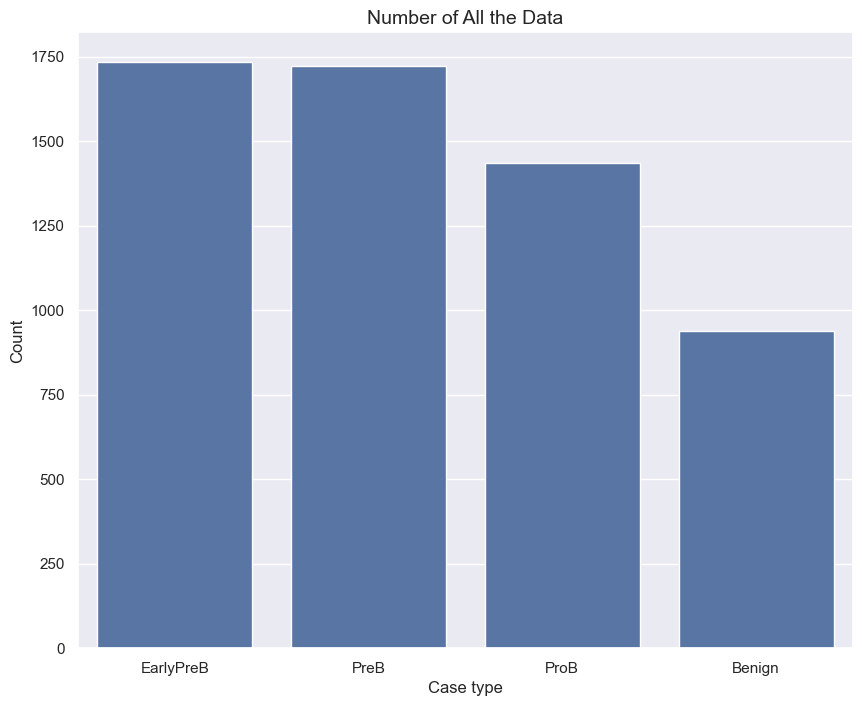

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#plt.xticks(range(len(df.index)), ['a', 'b'])
plt.show()

In [9]:

SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))
print(TRAIN_DF.shape)

Train samples:  5250
Valid samples:  584
Test samples :  325
(5250, 2)


In [22]:
test_df['labels'].value_counts()

labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64

In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation transformations
gen = ImageDataGenerator(rescale=1./255, 
                         vertical_flip=True,
                         horizontal_flip=True)

# Path to dataset (Update this with your actual path)
data_path = "E:/inc_new/tmp/prepared_data"  # Change as needed

# Iterate over each class folder
for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)

    if not os.path.isdir(class_path):  # Skip non-folder files
        continue

    print(f"Processing {class_folder}...")

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue  # Skip corrupted images

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = np.expand_dims(img, axis=0)  # Reshape for augmentation

        # Generate augmented images
        aug_iter = gen.flow(img, batch_size=1)

        for i in range(1):  # Create 1 augmented copy per image
            aug_img = next(aug_iter)[0] * 255  # Convert back to [0,255]
            aug_img = aug_img.astype(np.uint8)

            # Save the augmented image
            aug_filename = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            aug_filepath = os.path.join(class_path, aug_filename)
            cv2.imwrite(aug_filepath, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("Augmentation complete!")



Processing benign...
Processing EarlyPreB...
Processing PreB...
Processing ProB...
Augmentation complete!


In [14]:
import os

# Path to your dataset
prepared_data_path = "E:/inc_new/tmp/prepared_data"  # Update this with your actual path

# Count images per class
for class_folder in sorted(os.listdir(prepared_data_path)):  # Sorting for consistent output
    class_path = os.path.join(prepared_data_path, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a folder
        print(f"{class_folder}: {len(os.listdir(class_path))} images")


EarlyPreB: 1736 images
PreB: 1724 images
ProB: 1436 images
benign: 938 images


In [15]:
#base_model = InceptionV3(include_top= False, weights="imagenet", input_shape=(224,224,3))
base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.nasnet.NASNetLarge
#tf.keras.applications.nasnet.NASNetMobile

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) 
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x) 
model = Model(inputs=base_model.input, outputs=predictions) 

In [20]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

In [10]:
import os

# Root directory containing all subfolders
root_dir = "E:/inc_new/tmp/prepared_data"  # Change this to your actual path

# Iterate through all subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if "_aug0" in file:  # Check for augmentation pattern in filename
            file_path = os.path.join(subdir, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

print("Deletion completed.")


Deleted: E:/inc_new/tmp/prepared_data\benign\benign1003_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1008_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1010_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1014_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1018_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign101_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1025_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1029_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1034_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1039_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1047_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1048_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1056_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1058_aug0.jpg
Deleted: E:/inc_new/tmp/prepared_data\benign\benign1059_aug0.jpg
Deleted: E:/inc_new/tmp/pr

In [21]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)
STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
164


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restores the best weights from the best epoch
)

history = model.fit(
    x=train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[early_stopping]  # Add early stopping callback
)

C:\Users\dell\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.2637 - loss: 1.9701 - val_accuracy: 0.2774 - val_loss: 1.3900
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.2993 - loss: 1.7666 - val_accuracy: 0.2774 - val_loss: 1.4297
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.3222 - loss: 1.6722 - val_accuracy: 0.2877 - val_loss: 1.4042
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.3322 - loss: 1.6817 - val_accuracy: 0.3134 - val_loss: 1.3466
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.3303 - loss: 1.6328 - val_accuracy: 0.3562 - val_loss: 1.3015
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.3517 - loss: 1.5809 - val_accuracy: 0.3853 - val_loss: 1.2885
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.3673 - loss: 1.5920 - val_accuracy: 0.3921 - val_loss: 1.2738
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.3508 - loss: 1.5582 - val_accu

KeyboardInterrupt: 

In [19]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout

# Load EfficientNetB0 without top layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))

# Freeze base model initially
base_model.trainable = False  

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = BatchNormalization()(x)  # Normalize activations to stabilize training
x = Dropout(0.4)(x)  # Dropout to reduce overfitting
x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)  # Fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Another dropout layer for robustness
predictions = Dense(4, activation="softmax")(x)  # Output layer for classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Print summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 224, 224, 3)       │               7 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_3 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)